In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pint import UnitRegistry; AQ = UnitRegistry().Quantity
from scipy import optimize

In [2]:
%matplotlib inline

### First, let's reproduce what's in Fig. 11 of the paper
Need to do this because there are ambiguities in the paper:
- is $c_r$ in %, or a fraction? (Answer: the latter)
- is $\nu_{kin}$ in $\mu m \over sec$ or $layers \over \mu s$? (Answer: the latter)

In [3]:
nu_kin = AQ(49,'micrometer/second'); print('nu_kin',nu_kin)
layer_thicknesss = AQ(0.3,'nanometer')
nu_kin_ml = nu_kin/layer_thicknesss; 
nu_kin_ml.ito('1/microsecond')
print('nu_kin_ml',nu_kin_ml)
cr = AQ(0.0025,'dimensionless'); print('cr',cr) # center reduction is in fraction
D = AQ(2e-4,'micrometer**2/microsecond'); print('D',D)
L = AQ(25,'micrometer'); print('L',L)
beta = AQ(0.65,'dimensionless')
sigmaI = AQ(0.2,'dimensionless')
xfactor = nu_kin_ml*L**2*cr**beta*sigmaI/D
print('xfactor',xfactor)
M = AQ(.0027,'dimensionless')
B = AQ(2.9,'dimensionless')
NSS = M*xfactor + B
print('NSS',NSS)

nu_kin 49 micrometer / second
nu_kin_ml 0.1633333333333333 / microsecond
cr 0.0025 dimensionless
D 0.0002 micrometer ** 2 / microsecond
L 25 micrometer
xfactor 2077.8579213862818 dimensionless
NSS 8.510216387742961 dimensionless


### Now, the characteristic wavelength 
This is just $L  \over N_{SS}$. Analyically, expanding $N_{SS}$ gives

$$
\lambda = {L \over Mx+B} = {L \over M\nu_{kin} L^ 2 c_r^\beta \sigma_I/D+B} \ \ \ \ (1)
$$

or, defining a wavenumber $k ≡ {1 \over \lambda}$,

$$
k = {M\nu_{kin} L^ 2 c_r^\beta \sigma_I/D+B \over L} = {M\nu_{kin} L c_r^\beta \sigma_I \over D} + {B \over L} \ \ \ \ (2)
$$

In [4]:
# Solve for the characteristic wavelength
def getlamb(L,nu_kin_ml,cr,sigmaI,D,M,B):
    term1 = M*nu_kin_ml*L**2*cr**beta*sigmaI/D
    lamb = L/(term1+B)
    return lamb

lamb = getlamb(L,nu_kin_ml,cr,sigmaI,D,M,B)
print('lambda',lamb)
print('kval',1/lamb)
print('Just checking ... lambda = ', L/NSS)

lambda 2.937645632137725 micrometer
kval 0.34040865550971844 / micrometer
Just checking ... lambda =  2.937645632137725 micrometer


### Observations regarding Eq. 2
1. As the temperature goes up, both $\nu_{kin}$ and $D$ go up, so the effect on $k$ isn't obvious.
1. As the crystal gets bigger, the larger value of $L$ will tend to make the first term bigger, but the second term smaller. For these parameters, the former wins, and $k$ is bigger for larger crystals. 
1. We can also see that higher values of $\sigma_I$ (so faster-growing crystals), or bigger $c_r$ (probably associated with bigger crystals),  also give rise to bigger $k$.

### Connection to Turing?
According to Turing theory, 

$$
\lambda \approx (2 \pi \tau D)^{1 \over 2} \ \ \ \ (3)
$$

where $\tau$ is a "characteristic period of oscillation" (see, e.g., https://pubs.aip.org/aip/jcp/article-abstract/102/6/2551/481538/Dependence-of-Turing-pattern-wavelength-on?redirectedFrom=fulltext). Is it true here?

Well try something close to the above, but with an offset:

$$
\lambda \approx (2 \pi \tau D)^{1 \over 2} + b \ \ \ \ (4)
$$


In [5]:
# First generate some "experimental" data based on Eq. 1
Darray = np.linspace(D/2,D*2,10)
lambarray = getlamb(L,nu_kin_ml,cr,sigmaI,Darray,M,B)

tau_bestfit 10928.914756308775 microsecond
b_bestfit -0.7994434944270004 micrometer


/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


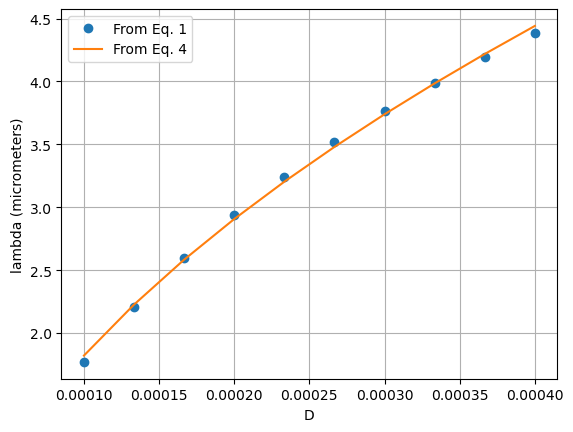

In [6]:
# Define a function corresponding to Eq. 4
def Eq4(D, tau, b):
    return (2*np.pi*tau*D)**.5+b

# Find best values for tau and b
params, params_covariance = optimize.curve_fit(Eq4, Darray.magnitude, lambarray.magnitude)  #subroutine to curve fit
tau_bestfit = AQ(params[0],'microsecond')
b_bestfit = AQ(params[1],'micrometer')
print('tau_bestfit',tau_bestfit)  
print('b_bestfit',b_bestfit)

# Generate values according to this theory
lambarray_theory = Eq4(Darray, tau_bestfit, b_bestfit)

# Plot
plt.figure()
plt.plot(Darray,lambarray,'o',label='From Eq. 1')
plt.plot(Darray,lambarray_theory,label='From Eq. 4')
plt.grid(True)
plt.xlabel('D')
plt.ylabel('lambda (micrometers)')
plt.legend()

### So what about that $\tau$?
What happens every $10,000 \ \mu s$?

In [10]:
# According to the paper, the time to grow a layer of ice
growthrate = AQ(1.85,'micrometers/second') # From Table 3 in the paper
growthrate /= layer_thicknesss
growthrate.ito('1/microsecond')
print('Growth rate',growthrate)
taulayer = 1/growthrate
print('Time to grow 1 layer =', taulayer)

# According to the paper, the time to reach steady-state
layers_to_steady_state = 350 # From Fig. 10 in the paper
time_to_steady_state = layers_to_steady_state * taulayer
print('Time to reach steady state =', time_to_steady_state)

# According to the paper, the average time to increment the number of steps (corner - center)
time_to_increment_1_toward_NSS = time_to_steady_state/NSS
print('Time to increment 1 toward NSS =',time_to_increment_1_toward_NSS)

# According to the paper, the time to increment the last number of steps (corner - center)
time_to_increment_last_1_before_NSS = 70*taulayer # From Fig. 10 in the paper
print('Time to increment last one toward NSS =',time_to_increment_last_1_before_NSS)

Growth rate 0.006166666666666666 / microsecond
Time to grow 1 layer = 162.1621621621622 microsecond
Time to reach steady state = 56756.75675675677 microsecond
Time to increment 1 toward NSS = 6669.249543231594 microsecond
Time to increment last one toward NSS = 11351.351351351354 microsecond


So ... the closest to $\tau$ we come to here is the time required to increment 1 toward $N_{SS}$ -- i.e., the time to add the last layer difference between the center and the corner, before reaching steady stat. Hard to see how that could be construed as a "characteristic oscillation," however.

### An alternative to Eq. 4 here

In [8]:
# # Do a curve-fit to that form
# p = np.polyfit(Darray.magnitude,lambarray.magnitude**2,1)
# m = p[0]; print('m =',m)
# b = p[1]; print('b =',b)

# lambarray_theory1 = (m*Darray.magnitude+b)**(1/2)
# lambarray_theory2 = (m*Darray.magnitude)**(1/2)

# plt.figure()
# plt.plot(Darray,lambarray,'o',label='From Eq. 1')
# plt.plot(Darray,lambarray_theory1,label='(m*D+b)^(1/2)')
# plt.plot(Darray,lambarray_theory2,label='(m*D)^(1/2)')
# plt.grid(True)
# plt.xlabel('D')
# plt.ylabel('lambda (micrometers)')
# plt.legend()
# tau = m/(2*np.pi); print('tau =', tau)